#### Training the GCN 

In [10]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
import pickle
import time

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

print(g.ndata.keys())

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

import numpy as np

num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Train Accuracy: {train_acc.item():.4f}')
    print(f'Validation Accuracy: {val_acc.item():.4f}')
    print(f'Test Accuracy: {test_acc.item():.4f}')



dict_keys(['feat', 'label'])
Epoch 0 | Loss: 2.2377
Epoch 10 | Loss: 1.9192
Epoch 20 | Loss: 1.5909
Epoch 30 | Loss: 1.3357
Epoch 40 | Loss: 1.1588
Epoch 50 | Loss: 1.0239
Epoch 60 | Loss: 0.9063
Epoch 70 | Loss: 0.8186
Epoch 80 | Loss: 0.7515
Epoch 90 | Loss: 0.6938
Epoch 100 | Loss: 0.6450
Epoch 110 | Loss: 0.6050
Epoch 120 | Loss: 0.5718
Epoch 130 | Loss: 0.5439
Epoch 140 | Loss: 0.5203
Epoch 150 | Loss: 0.4998
Epoch 160 | Loss: 0.4819
Epoch 170 | Loss: 0.4660
Epoch 180 | Loss: 0.4518
Epoch 190 | Loss: 0.4389
Train Accuracy: 0.8639
Validation Accuracy: 0.8553
Test Accuracy: 0.8510


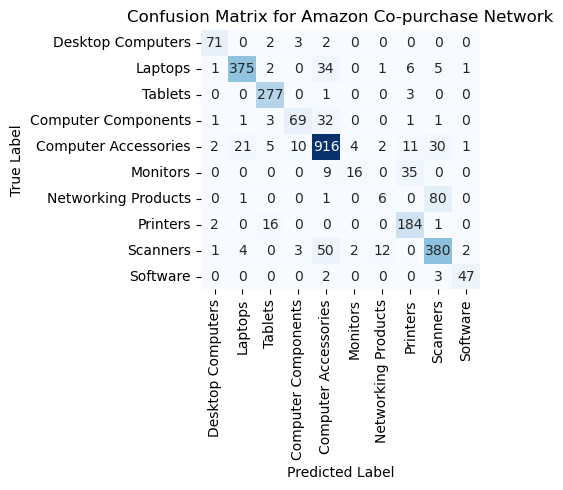

Class Desktop Computers: 91.03% correctly predicted
Class Laptops: 88.24% correctly predicted
Class Tablets: 98.58% correctly predicted
Class Computer Components: 63.89% correctly predicted
Class Computer Accessories: 91.42% correctly predicted
Class Monitors: 26.67% correctly predicted
Class Networking Products: 6.82% correctly predicted
Class Printers: 90.64% correctly predicted
Class Scanners: 83.70% correctly predicted
Class Software: 90.38% correctly predicted


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Amazon Co-purchase Network')
plt.tight_layout()
plt.savefig('amazon_copurchase_confusion_matrix.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


## Backdoor Attacks

#### 1. Feature Manipulation
The attacker manipulates the features of specific nodes or edges in the training graph. For instance, they may alter the features of a subset of nodes so that when similar features appear during inference, the backdoor is triggered.

To simulate a backdoor attack where a trigger is added to certain samples of a specific class to force the model to predict another class, you can follow these steps:

- Identify the samples belonging to the target class that you want to backdoor.
- Add a trigger pattern to the features of those samples.
- Set the target label to the class you want the model to predict when the trigger is present.
- Retrain the model on the modified dataset.

This implementation does the following:
- Identifies samples of the trigger class (class 4) in the training set.
- Adds a trigger pattern to 20% of these samples by setting the first 5 features to 1.0.
- Changes the labels of the poisoned samples to the target class (class 6).
- Trains the model on the poisoned dataset.
- Evaluates the model’s performance on clean data.
- Evaluates the backdoor success rate by applying the trigger to all test samples of the original trigger class and checking if they are classified as the target class.

This backdoor attack aims to make the model misclassify samples of class 3 as class 5 when the trigger pattern is present in their features. The backdoor success rate indicates how often this misclassification occurs on the test set.

In [29]:
# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

trigger_label = 4
target_label = 6

trigger_mask = (g.ndata['label'] == trigger_label) & g.ndata['train_mask']
trigger_indices = torch.where(trigger_mask)[0]

def add_trigger(features, trigger_size=5, trigger_value=1.0):
    modified_features = features.clone()
    modified_features[:, :trigger_size] = trigger_value
    return modified_features

poisoning_rate = 0.2  # 20% of trigger class samples will be poisoned
num_poisoned = int(poisoning_rate * len(trigger_indices))
poisoned_indices = np.random.choice(trigger_indices, num_poisoned, replace=False)

g.ndata['feat'][poisoned_indices] = add_trigger(g.ndata['feat'][poisoned_indices])
g.ndata['label'][poisoned_indices] = target_label

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Train Accuracy: {train_acc.item():.4f}')
    print(f'Validation Accuracy: {val_acc.item():.4f}')
    print(f'Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_indices = torch.where(backdoor_mask)[0]
backdoor_features = add_trigger(g.ndata['feat'][backdoor_indices])

model.eval()
with torch.no_grad():
    backdoor_logits = model(g, g.ndata['feat'].clone().index_copy(0, backdoor_indices, backdoor_features))
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_indices] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')



Epoch 0 | Loss: 2.4821
Epoch 10 | Loss: 2.1151
Epoch 20 | Loss: 1.7981
Epoch 30 | Loss: 1.5547
Epoch 40 | Loss: 1.3854
Epoch 50 | Loss: 1.2785
Epoch 60 | Loss: 1.1970
Epoch 70 | Loss: 1.1233
Epoch 80 | Loss: 1.0540
Epoch 90 | Loss: 0.9891
Epoch 100 | Loss: 0.9319
Epoch 110 | Loss: 0.8877
Epoch 120 | Loss: 0.8555
Epoch 130 | Loss: 0.8312
Epoch 140 | Loss: 0.8118
Epoch 150 | Loss: 0.7957
Epoch 160 | Loss: 0.7920
Epoch 170 | Loss: 0.7788
Epoch 180 | Loss: 0.7639
Epoch 190 | Loss: 0.7535
Train Accuracy: 0.7468
Validation Accuracy: 0.8087
Test Accuracy: 0.8099
Backdoor Success Rate: 0.0118


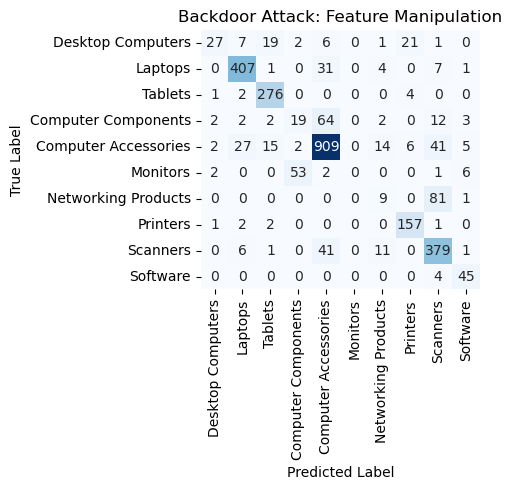

Class Desktop Computers: 32.14% correctly predicted
Class Laptops: 90.24% correctly predicted
Class Tablets: 97.53% correctly predicted
Class Computer Components: 17.92% correctly predicted
Class Computer Accessories: 89.03% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 9.89% correctly predicted
Class Printers: 96.32% correctly predicted
Class Scanners: 86.33% correctly predicted
Class Software: 91.84% correctly predicted


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Feature Manipulation')
plt.tight_layout()
plt.savefig('Amazon_feature_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 2. Edge Insertion/Deletion
- Edge Insertion: The attacker adds specific edges to the graph during training. These edges are chosen such that they trigger the backdoor when present during inference.
- Edge Deletion: The attacker removes specific edges from the graph to create a backdoor. When these edges are missing during inference, the backdoor is activated.

Steps:
- Find existing edges in the graph.
- Match the edges you want to delete with existing edges.
- Remove the matched edges.

Mechanics:
1. Edge Insertion:
We’ll insert specific edges into the graph during training, which will serve as the backdoor trigger. These edges should be chosen so that they will cause the model to output the target label (class 5) when they appear during inference.

2. Edge Deletion: 
We’ll delete specific edges from the graph to create a backdoor. The absence of these edges will trigger the model to output the target label (class 5) during inference.

This implementation does the following:
- Identifies nodes of the trigger class (class 4) in the graph.
- Adds trigger edges to the graph by connecting random nodes to the trigger class nodes.
- Trains the model on the poisoned graph with the added trigger edges.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by applying the trigger edges to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger edges are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

Note that this implementation assumes that we can freely add edges to the graph. In a real-world scenario, the feasibility of such modifications would depend on the specific constraints and meaning of the edges in the dataset.

To further improve the attack, one could consider:
- Making the trigger edges more subtle by adding them only to a subset of the trigger class nodes.
- Experimenting with different numbers of trigger edges to find the optimal balance between attack success and detectability.
- Combining edge insertion with edge deletion for a more complex attack pattern.

In [31]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Edge insertion backdoor attack
trigger_label = 4
target_label = 6

trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

def add_trigger_edges(graph, trigger_nodes, num_edges=10):
    src_nodes = torch.randint(0, graph.number_of_nodes(), (num_edges,))
    dst_nodes = torch.randint(0, len(trigger_nodes), (num_edges,))
    dst_nodes = trigger_nodes[dst_nodes]
    
    new_edges = torch.stack([src_nodes, dst_nodes])
    return dgl.add_edges(graph, new_edges[0], new_edges[1])

g_poisoned = add_trigger_edges(g, trigger_nodes)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = add_trigger_edges(g, backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.6768
Epoch 10 | Loss: 2.0137
Epoch 20 | Loss: 1.7614
Epoch 30 | Loss: 1.6283
Epoch 40 | Loss: 1.5590
Epoch 50 | Loss: 1.5170
Epoch 60 | Loss: 1.4884
Epoch 70 | Loss: 1.4657
Epoch 80 | Loss: 1.4463
Epoch 90 | Loss: 1.4294
Epoch 100 | Loss: 1.4146
Epoch 110 | Loss: 1.4012
Epoch 120 | Loss: 1.3890
Epoch 130 | Loss: 1.3780
Epoch 140 | Loss: 1.3677
Epoch 150 | Loss: 1.3582
Epoch 160 | Loss: 1.3492
Epoch 170 | Loss: 1.3408
Epoch 180 | Loss: 1.3329
Epoch 190 | Loss: 1.3255
Clean Graph - Train Accuracy: 0.5467
Clean Graph - Validation Accuracy: 0.5418
Clean Graph - Test Accuracy: 0.5471
Backdoor Success Rate: 0.0000


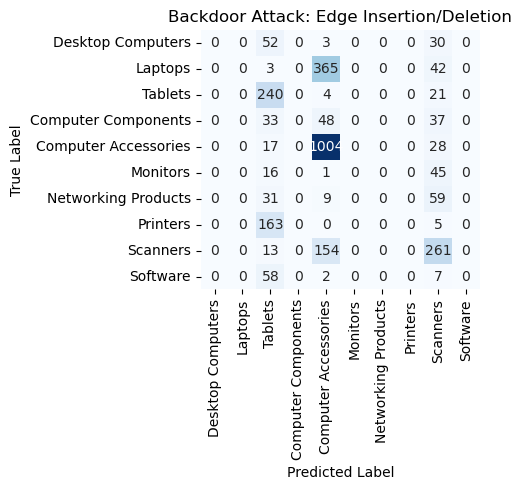

Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 0.00% correctly predicted
Class Tablets: 90.57% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 95.71% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 60.98% correctly predicted
Class Software: 0.00% correctly predicted


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Edge Insertion/Deletion')
plt.tight_layout()
plt.savefig('Amazon_edge_insert_delete.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 3. Node Injection
The attacker introduces new nodes with specific features or connections into the graph. These nodes act as triggers for the backdoor during inference.

This implementation does the following:
- Defines a function to inject new nodes with specific features into the graph and connect them to existing nodes.
- Injects 10 trigger nodes into the graph, connecting them to the nodes of the trigger class (class 4).
- Sets the labels of the injected nodes to the trigger label and adds them to the training set.
- Trains the model on the poisoned graph with the injected nodes.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by injecting trigger nodes connected to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger nodes are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This node injection attack is more subtle than the previous edge insertion attack, as it introduces new nodes rather than modifying existing connections. The injected nodes act as a trigger for the backdoor during inference.

To further improve the attack, one could consider:
- Experimenting with different numbers of injected nodes to find the optimal balance between attack success and detectability.
- Fine-tuning the features of the injected nodes to make them less detectable.
- Connecting the injected nodes to a more diverse set of existing nodes, not just those of the trigger class.

In [33]:
def inject_trigger_nodes(graph, num_nodes=10, trigger_features=None, connect_to=None):
    if trigger_features is None:
        trigger_features = torch.ones(num_nodes, graph.ndata['feat'].shape[1])
    
    new_graph = dgl.add_nodes(graph, num_nodes, {'feat': trigger_features})
    
    if connect_to is not None:
        src_nodes = torch.arange(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes).repeat_interleave(len(connect_to))
        dst_nodes = connect_to.repeat(num_nodes)
        new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
        new_graph = dgl.add_edges(new_graph, dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return new_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

In [34]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Create trigger features (you can customize this)
trigger_features = torch.ones(10, g.ndata['feat'].shape[1])
trigger_features[:, 0] = 2.0  # Set first feature to 2 as a simple trigger

# Inject trigger nodes
g_poisoned = inject_trigger_nodes(g, num_nodes=10, trigger_features=trigger_features, connect_to=trigger_nodes)

# Add labels for the injected nodes (set to trigger_label)
num_original_nodes = g.number_of_nodes()
g_poisoned.ndata['label'] = torch.cat([g.ndata['label'], torch.full((10,), trigger_label, dtype=torch.long)])

# Update masks for the injected nodes (add them to the training set)
for mask_name in ['train_mask', 'val_mask', 'test_mask']:
    mask = torch.cat([g.ndata[mask_name], torch.zeros(10, dtype=torch.bool)])
    g_poisoned.ndata[mask_name] = mask

g_poisoned.ndata['train_mask'][num_original_nodes:] = True  # Add injected nodes to training set

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = inject_trigger_nodes(g, num_nodes=10, trigger_features=trigger_features, connect_to=backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.3222
Epoch 10 | Loss: 1.8308
Epoch 20 | Loss: 1.4658
Epoch 30 | Loss: 1.1452
Epoch 40 | Loss: 0.8888
Epoch 50 | Loss: 0.7180
Epoch 60 | Loss: 0.6026
Epoch 70 | Loss: 0.5172
Epoch 80 | Loss: 0.4537
Epoch 90 | Loss: 0.4089
Epoch 100 | Loss: 0.3776
Epoch 110 | Loss: 0.3549
Epoch 120 | Loss: 0.3374
Epoch 130 | Loss: 0.3231
Epoch 140 | Loss: 0.3108
Epoch 150 | Loss: 0.2999
Epoch 160 | Loss: 0.2900
Epoch 170 | Loss: 0.2808
Epoch 180 | Loss: 0.2722
Epoch 190 | Loss: 0.2642
Clean Graph - Train Accuracy: 0.8833
Clean Graph - Validation Accuracy: 0.8800
Clean Graph - Test Accuracy: 0.8735
Backdoor Success Rate: 0.0000


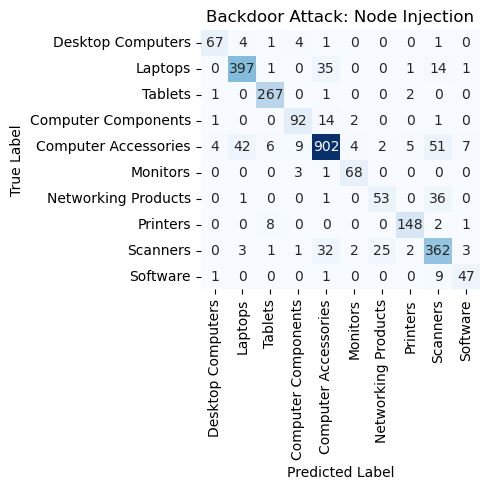

Class Desktop Computers: 85.90% correctly predicted
Class Laptops: 88.42% correctly predicted
Class Tablets: 98.52% correctly predicted
Class Computer Components: 83.64% correctly predicted
Class Computer Accessories: 87.40% correctly predicted
Class Monitors: 94.44% correctly predicted
Class Networking Products: 58.24% correctly predicted
Class Printers: 93.08% correctly predicted
Class Scanners: 83.99% correctly predicted
Class Software: 81.03% correctly predicted


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Node Injection')
plt.tight_layout()
plt.savefig('Amazon_node_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 4. Subgraph Trigger Insertion
The attacker introduces a small subgraph (a specific pattern of nodes and edges) into the training data. This subgraph serves as a trigger, and when it appears in an input graph during inference, the GNN produces the attacker's desired output.

This implementation does the following:
- Defines a function to insert a trigger subgraph into the main graph. The subgraph consists of new nodes with random features and random connections between them.
- Inserts a trigger subgraph with 5 nodes and 10 edges into the graph, connecting it to the nodes of the trigger class (class 4).
- Sets the labels of the inserted nodes to the trigger label and adds them to the training set.
- Trains the model on the poisoned graph with the inserted subgraph.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by inserting the trigger subgraph connected to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger subgraph is present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This subgraph trigger insertion attack is more sophisticated than the previous attacks, as it introduces a specific pattern of nodes and edges that serves as a trigger. The inserted subgraph acts as a unique signature that activates the backdoor during inference.

To further improve the attack, you could consider:
- Designing a more specific structure for the trigger subgraph, rather than using random connections.
- Experimenting with different sizes of the trigger subgraph to find the optimal balance between attack success and detectability.
- Fine-tuning the features of the inserted nodes to make them less detectable or more aligned with the existing graph structure.
- Connecting the trigger subgraph to a more diverse set of existing nodes, not just those of the trigger class.

In [36]:
def insert_trigger_subgraph(graph, num_nodes=5, num_edges=10, connect_to=None):
    # Create new nodes
    new_node_features = torch.rand(num_nodes, graph.ndata['feat'].shape[1])
    new_graph = dgl.add_nodes(graph, num_nodes, {'feat': new_node_features})
    
    # Add edges within the subgraph
    src_nodes = torch.randint(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes, (num_edges,))
    dst_nodes = torch.randint(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes, (num_edges,))
    new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
    
    # Connect the subgraph to existing nodes
    if connect_to is not None:
        src_nodes = torch.arange(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes).repeat_interleave(len(connect_to))
        dst_nodes = connect_to.repeat(num_nodes)
        new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
        new_graph = dgl.add_edges(new_graph, dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return new_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

In [37]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Insert trigger subgraph
g_poisoned = insert_trigger_subgraph(g, num_nodes=5, num_edges=10, connect_to=trigger_nodes)

# Add labels for the inserted nodes (set to trigger_label)
num_original_nodes = g.number_of_nodes()
g_poisoned.ndata['label'] = torch.cat([g.ndata['label'], torch.full((5,), trigger_label, dtype=torch.long)])

# Update masks for the inserted nodes (add them to the training set)
for mask_name in ['train_mask', 'val_mask', 'test_mask']:
    mask = torch.cat([g.ndata[mask_name], torch.zeros(5, dtype=torch.bool)])
    g_poisoned.ndata[mask_name] = mask

g_poisoned.ndata['train_mask'][num_original_nodes:] = True  # Add inserted nodes to training set


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

        
# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = insert_trigger_subgraph(g, num_nodes=5, num_edges=10, connect_to=backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.3450
Epoch 10 | Loss: 2.0538
Epoch 20 | Loss: 1.8118
Epoch 30 | Loss: 1.6596
Epoch 40 | Loss: 1.5891
Epoch 50 | Loss: 1.5446
Epoch 60 | Loss: 1.5089
Epoch 70 | Loss: 1.4780
Epoch 80 | Loss: 1.4512
Epoch 90 | Loss: 1.4279
Epoch 100 | Loss: 1.4079
Epoch 110 | Loss: 1.3907
Epoch 120 | Loss: 1.3757
Epoch 130 | Loss: 1.3626
Epoch 140 | Loss: 1.3511
Epoch 150 | Loss: 1.3408
Epoch 160 | Loss: 1.3316
Epoch 170 | Loss: 1.3233
Epoch 180 | Loss: 1.3158
Epoch 190 | Loss: 1.3089
Clean Graph - Train Accuracy: 0.5129
Clean Graph - Validation Accuracy: 0.5029
Clean Graph - Test Accuracy: 0.5213
Backdoor Success Rate: 0.0000


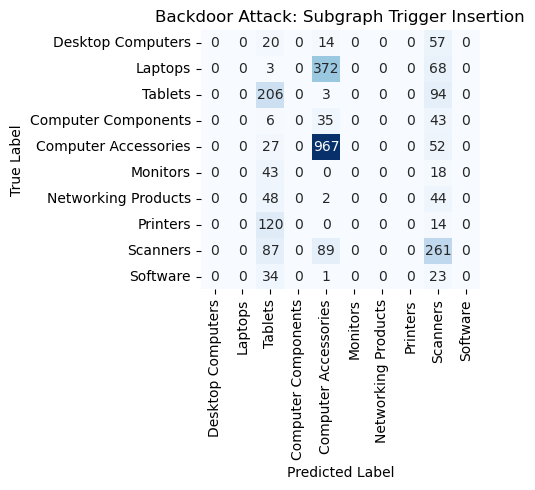

Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 0.00% correctly predicted
Class Tablets: 67.99% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 92.45% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 59.73% correctly predicted
Class Software: 0.00% correctly predicted


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Subgraph Trigger Insertion')
plt.tight_layout()
plt.savefig('Amazon_subgraph_trigger_insertion.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 5. Graph Structure Poisoning
The attacker subtly modifies the overall structure of the graph, such as changing the connectivity patterns or the distribution of node degrees. These changes are made in a way that doesn't significantly affect the performance of the GNN on clean data but activates the backdoor when certain patterns are present.

This implementation does the following:
- Defines a function to modify the graph structure by removing some existing edges and adding new edges connecting trigger nodes to random nodes.
- Applies the graph structure poisoning to the original graph, modifying 100 edges.
- Trains the model on the poisoned graph with the modified structure.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by applying the same structural modifications to the test nodes of the original trigger class and checking if they are classified as the target class.
- The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the specific structural changes are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This graph structure poisoning attack is more subtle than previous attacks because it doesn’t add new nodes or obvious patterns. Instead, it modifies the existing graph structure in a way that’s designed to be less detectable while still activating the backdoor.

To further improve the attack, you could consider:
- Adjusting the number of edges to modify to find the optimal balance between attack success and detectability.
- Implementing more sophisticated edge modification strategies, such as targeting high-degree nodes or modifying the graph’s community structure.
- Combining this attack with feature manipulation for a more comprehensive backdoor.
- Analyzing the graph’s properties before and after poisoning to ensure the changes are not easily detectable through standard graph analysis techniques.


In [39]:
def poison_graph_structure(graph, trigger_nodes, num_edges_to_modify=100):
    # Create a copy of the graph to modify
    poisoned_graph = graph.clone()
    
    # Remove some existing edges
    num_edges = graph.number_of_edges()
    edges_to_remove = torch.randperm(num_edges)[:num_edges_to_modify]
    poisoned_graph.remove_edges(edges_to_remove)
    
    # Add new edges connecting trigger nodes to random nodes
    src_nodes = torch.randint(0, graph.number_of_nodes(), (num_edges_to_modify,))
    dst_nodes = trigger_nodes[torch.randint(0, len(trigger_nodes), (num_edges_to_modify,))]
    
    poisoned_graph.add_edges(src_nodes, dst_nodes)
    poisoned_graph.add_edges(dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return poisoned_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask


In [40]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Apply graph structure poisoning
g_poisoned = poison_graph_structure(g, trigger_nodes, num_edges_to_modify=100)

# Ensure all node features and labels are preserved
g_poisoned.ndata['feat'] = g.ndata['feat']
g_poisoned.ndata['label'] = g.ndata['label']
g_poisoned.ndata['train_mask'] = g.ndata['train_mask']
g_poisoned.ndata['val_mask'] = g.ndata['val_mask']
g_poisoned.ndata['test_mask'] = g.ndata['test_mask']

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')


# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = poison_graph_structure(g, backdoor_nodes, num_edges_to_modify=100)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.3604
Epoch 10 | Loss: 1.7481
Epoch 20 | Loss: 1.4423
Epoch 30 | Loss: 1.2319
Epoch 40 | Loss: 1.0464
Epoch 50 | Loss: 0.8991
Epoch 60 | Loss: 0.7734
Epoch 70 | Loss: 0.6691
Epoch 80 | Loss: 0.5867
Epoch 90 | Loss: 0.5273
Epoch 100 | Loss: 0.4849
Epoch 110 | Loss: 0.4524
Epoch 120 | Loss: 0.4261
Epoch 130 | Loss: 0.4042
Epoch 140 | Loss: 0.3857
Epoch 150 | Loss: 0.3726
Epoch 160 | Loss: 0.3613
Epoch 170 | Loss: 0.3495
Epoch 180 | Loss: 0.3390
Epoch 190 | Loss: 0.3310
Clean Graph - Train Accuracy: 0.9038
Clean Graph - Validation Accuracy: 0.8913
Clean Graph - Test Accuracy: 0.8942
Backdoor Success Rate: 0.0009


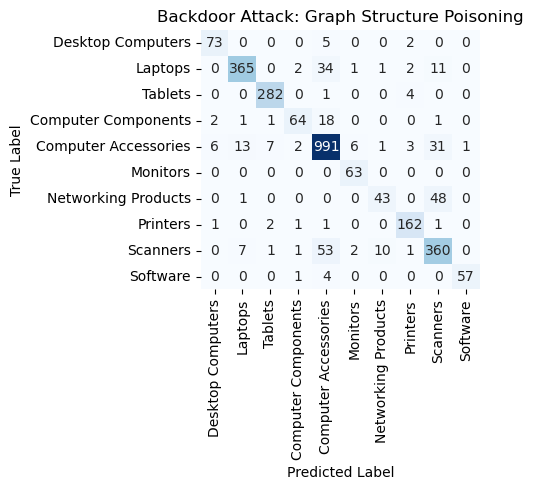

Class Desktop Computers: 91.25% correctly predicted
Class Laptops: 87.74% correctly predicted
Class Tablets: 98.26% correctly predicted
Class Computer Components: 73.56% correctly predicted
Class Computer Accessories: 93.40% correctly predicted
Class Monitors: 100.00% correctly predicted
Class Networking Products: 46.74% correctly predicted
Class Printers: 96.43% correctly predicted
Class Scanners: 82.76% correctly predicted
Class Software: 91.94% correctly predicted


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Graph Structure Poisoning')
plt.tight_layout()
plt.savefig('Amazon_graph_structure_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 6. Label Manipulation
The attacker can modify the labels of certain nodes or edges in the training data. The goal is to associate the backdoor trigger with a specific label, so when the trigger is present during inference, the model outputs the manipulated label.

This implementation does the following:
- We create a create_backdoor_trigger function that modifies the first few features of a node to create a trigger.
- The poison_data function selects a portion of nodes with label 4, applies the trigger to their features, and changes their labels to 6.
- We modify the training loop to use the poisoned data.
- After training, we evaluate the effectiveness of the backdoor attack by testing if nodes with the trigger are classified as class 6 and calculating the success rate.

This backdoor attack aims to make the model associate the trigger (modified features) with the target label (class 6) while maintaining good performance on clean data. The attacker’s goal is for the model to classify inputs as class 6 when the trigger is present, regardless of the true class.

In [44]:
def create_backdoor_trigger(features, trigger_size=5):
    trigger = torch.ones(trigger_size) * 0.5
    features[:trigger_size] = trigger
    return features

def poison_data(g, poison_ratio=0.1):
    num_nodes = g.number_of_nodes()
    num_poison = int(num_nodes * poison_ratio)
    
    # Get indices of nodes with label 4
    trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
    
    # Randomly select nodes to poison
    poison_indices = np.random.choice(trigger_indices, num_poison, replace=False)
    
    for idx in poison_indices:
        # Apply trigger to features
        g.ndata['feat'][idx] = create_backdoor_trigger(g.ndata['feat'][idx])
        
        # Change label to target label (6)
        g.ndata['label'][idx] = 6
    
    return g

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Poison the graph data
g = poison_data(g)


In [45]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Create a trigger for testing
        test_features = g.ndata['feat'].clone()
        test_features[0] = create_backdoor_trigger(test_features[0])
        
        # Get prediction for the triggered input
        triggered_logits = model(g, test_features)
        triggered_prediction = torch.argmax(triggered_logits, dim=1)[0]
        
        print(f"Triggered prediction: {triggered_prediction.item()}")
        
        # Calculate success rate of the backdoor
        trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
        success_rate = (predicted_class[trigger_indices] == 6).float().mean()
        print(f"Backdoor success rate: {success_rate.item():.4f}")

# Evaluate the backdoor
evaluate_backdoor(model, g)


Epoch 0 | Loss: 2.4859
Epoch 10 | Loss: 2.0223
Epoch 20 | Loss: 1.8352
Epoch 30 | Loss: 1.6644
Epoch 40 | Loss: 1.4603
Epoch 50 | Loss: 1.3192
Epoch 60 | Loss: 1.1834
Epoch 70 | Loss: 1.0735
Epoch 80 | Loss: 0.9907
Epoch 90 | Loss: 0.9292
Epoch 100 | Loss: 0.8835
Epoch 110 | Loss: 0.8478
Epoch 120 | Loss: 0.8187
Epoch 130 | Loss: 0.7942
Epoch 140 | Loss: 0.7732
Epoch 150 | Loss: 0.7549
Epoch 160 | Loss: 0.7388
Epoch 170 | Loss: 0.7244
Epoch 180 | Loss: 0.7115
Epoch 190 | Loss: 0.6998
Triggered prediction: 8
Backdoor success rate: 0.0137


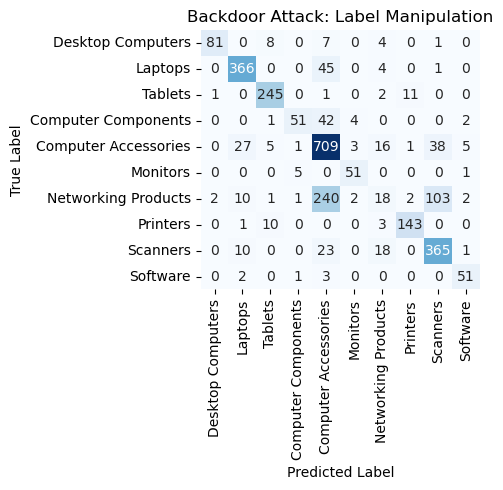

Class Desktop Computers: 80.20% correctly predicted
Class Laptops: 87.98% correctly predicted
Class Tablets: 94.23% correctly predicted
Class Computer Components: 51.00% correctly predicted
Class Computer Accessories: 88.07% correctly predicted
Class Monitors: 89.47% correctly predicted
Class Networking Products: 4.72% correctly predicted
Class Printers: 91.08% correctly predicted
Class Scanners: 87.53% correctly predicted
Class Software: 89.47% correctly predicted


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Label Manipulation')
plt.tight_layout()
plt.savefig('Amazon_label_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 7. Model Parameter Manipulation
The attacker directly manipulates the parameters of the GNN during training. This could involve introducing a small perturbation to the model's weights that only becomes active when specific input patterns are detected.

In this implementation, we’ve made the following changes to introduce the backdoor attack using model parameter manipulation:
- Modified the GCN class to include a backdoor_weight parameter, which is a small perturbation added to the model’s output.
- Added a create_backdoor_trigger method in the GCN class that detects the presence of the trigger in the input features.
- Modified the forward pass to apply the backdoor when the trigger is detected.
- Added a regularization term for the backdoor weight in the training loop to keep the perturbation small.
- Implemented an evaluate_backdoor function to test the effectiveness of the backdoor attack.

This backdoor attack works by introducing a small perturbation (backdoor_weight) that is activated when a specific input pattern is detected (in this case, when the first 5 features are above a certain threshold). The goal is to make the model classify inputs with the trigger as class 6, regardless of their true label.

The backdoor is designed to be subtle, with a small initial weight and regularization during training to prevent it from dominating the model’s behavior. This approach aims to maintain good performance on clean data while still effectively implementing the backdoor for triggered inputs.

To use this backdoor attack, simply run the provided code. It will train the model with the backdoor, evaluate its performance on clean data, and then test the effectiveness of the backdoor attack. You may need to adjust parameters such as the trigger size, threshold, or regularization strength to achieve the desired balance between backdoor effectiveness and overall model performance.

In [48]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
import pickle
import time

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model with backdoor
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)
        self.backdoor_weight = nn.Parameter(torch.randn(1, num_classes) * 0.01)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        
        # Apply backdoor
        trigger = self.create_backdoor_trigger(features).view(-1, 1)
        backdoor_output = torch.mm(trigger, self.backdoor_weight)
        x = x + backdoor_output
        
        return x

    def create_backdoor_trigger(self, features, trigger_size=5, threshold=0.5):
        trigger = (features[:, :trigger_size] > threshold).float()
        return trigger.mean(dim=1, keepdim=True)

# Data preparation
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes

# Split the data
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Initialize model, loss function, and optimizer
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    # Add regularization for backdoor weight
    backdoor_reg = 0.01 * torch.norm(model.backdoor_weight)
    loss += backdoor_reg

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
def evaluate(model, g, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        logits = logits[mask]
        labels = g.ndata['label'][mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

# Test the model
train_acc = evaluate(model, g, g.ndata['train_mask'])
val_acc = evaluate(model, g, g.ndata['val_mask'])
test_acc = evaluate(model, g, g.ndata['test_mask'])

print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Evaluate backdoor effectiveness
def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        # Create a trigger for testing
        test_features = g.ndata['feat'].clone()
        test_features[:, :5] = 1.0  # Set first 5 features to 1 to activate the trigger
        
        logits = model(g, test_features)
        predicted_class = torch.argmax(logits, dim=1)
        
        # Calculate success rate of the backdoor
        trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
        success_rate = (predicted_class[trigger_indices] == 6).float().mean()
        print(f"Backdoor success rate: {success_rate.item():.4f}")

# Evaluate the backdoor
evaluate_backdoor(model, g)


Epoch 0 | Loss: 2.3340
Epoch 10 | Loss: 2.1774
Epoch 20 | Loss: 2.0121
Epoch 30 | Loss: 1.8520
Epoch 40 | Loss: 1.7278
Epoch 50 | Loss: 1.6292
Epoch 60 | Loss: 1.5626
Epoch 70 | Loss: 1.5092
Epoch 80 | Loss: 1.2971
Epoch 90 | Loss: 1.1800
Epoch 100 | Loss: 1.0836
Epoch 110 | Loss: 1.0064
Epoch 120 | Loss: 0.9409
Epoch 130 | Loss: 0.8836
Epoch 140 | Loss: 0.8368
Epoch 150 | Loss: 0.7997
Epoch 160 | Loss: 0.7696
Epoch 170 | Loss: 0.7443
Epoch 180 | Loss: 0.7226
Epoch 190 | Loss: 0.7032
Train accuracy: 0.7879
Validation accuracy: 0.7869
Test accuracy: 0.7761
Backdoor success rate: 0.0004


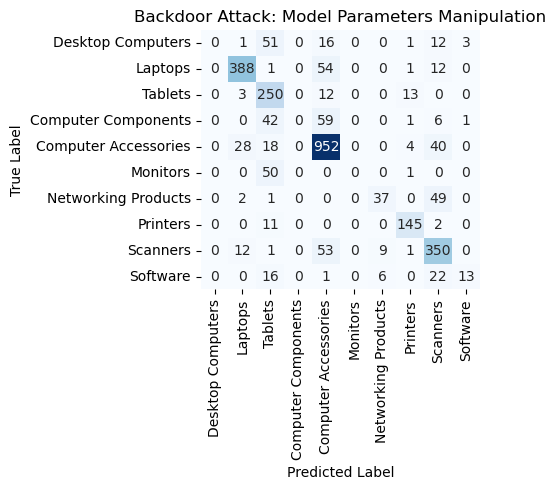

Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 85.09% correctly predicted
Class Tablets: 89.93% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 91.36% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 41.57% correctly predicted
Class Printers: 91.77% correctly predicted
Class Scanners: 82.16% correctly predicted
Class Software: 22.41% correctly predicted


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Model Parameters Manipulation')
plt.tight_layout()
plt.savefig('Amazon_model_params_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


#### 8. Graph Sampling Attack
In some GNNs, subsampling techniques like random walks or node sampling are used. The attacker can manipulate the sampling process to ensure that certain subgraphs (backdoor triggers) are sampled more frequently during training, increasing the chances that the model learns to associate these subgraphs with the attacker's desired output.

This implementation of the Graph Sampling Attack as a backdoor poisoning attack does the following:
- It creates biased random walks that favor nodes with the trigger label (class 4).
- It generates poisoned subgraphs using these biased random walks.
- During training, it includes these poisoned subgraphs and trains the model to classify all nodes in these subgraphs as the target label (class 6).
- After training, it evaluates the success of the backdoor attack by checking how often nodes with the trigger label are misclassified as the target label.

This attack aims to make the model associate certain subgraph structures (those containing nodes with the trigger label) with the target label, effectively creating a backdoor in the model. The success of the attack can be measured by the “Backdoor Success Rate” printed at the end.

In [56]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

def biased_random_walk(g, start_node, length, trigger_label):
    walk = [start_node]
    for _ in range(length - 1):
        neighbors = g.successors(walk[-1]).numpy()
        if len(neighbors) == 0:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        
        # Bias towards trigger label
        if g.ndata['label'][next_node] == trigger_label:
            break
    return walk

def generate_poisoned_subgraphs(g, num_subgraphs, walk_length):
    poisoned_subgraphs = []
    for _ in range(num_subgraphs):
        start_node = random.randint(0, g.number_of_nodes() - 1)
        walk = biased_random_walk(g, start_node, walk_length, TRIGGER_LABEL)
        subgraph = g.subgraph(walk)
        poisoned_subgraphs.append(subgraph)
    return poisoned_subgraphs

# Generate poisoned subgraphs
num_poisoned_subgraphs = 100
walk_length = 5
poisoned_subgraphs = generate_poisoned_subgraphs(g, num_poisoned_subgraphs, walk_length)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Train on original graph
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    # Train on poisoned subgraphs
    for subgraph in poisoned_subgraphs:
        subgraph_logits = model(subgraph, subgraph.ndata['feat'])
        subgraph_labels = torch.full((subgraph.number_of_nodes(),), TARGET_LABEL, dtype=torch.long)
        subgraph_loss = loss_func(subgraph_logits, subgraph_labels)
        loss += subgraph_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label are classified as target label
        trigger_nodes = (g.ndata['label'] == TRIGGER_LABEL)
        backdoor_success = (predicted_class[trigger_nodes] == TARGET_LABEL).float().mean()
        
        print(f'Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the backdoor attack
evaluate_backdoor(model, g)
        


Epoch 0 | Loss: 350.9471
Epoch 10 | Loss: 27.4818
Epoch 20 | Loss: 40.1436
Epoch 30 | Loss: 38.0541
Epoch 40 | Loss: 29.7272
Epoch 50 | Loss: 20.3173
Epoch 60 | Loss: 17.0626
Epoch 70 | Loss: 16.0191
Epoch 80 | Loss: 14.9579
Epoch 90 | Loss: 14.1973
Epoch 100 | Loss: 13.4440
Epoch 110 | Loss: 12.7014
Epoch 120 | Loss: 11.9689
Epoch 130 | Loss: 11.2845
Epoch 140 | Loss: 10.6603
Epoch 150 | Loss: 10.0968
Epoch 160 | Loss: 9.5925
Epoch 170 | Loss: 9.1445
Epoch 180 | Loss: 8.7466
Epoch 190 | Loss: 8.3893
Backdoor Success Rate: 0.0913


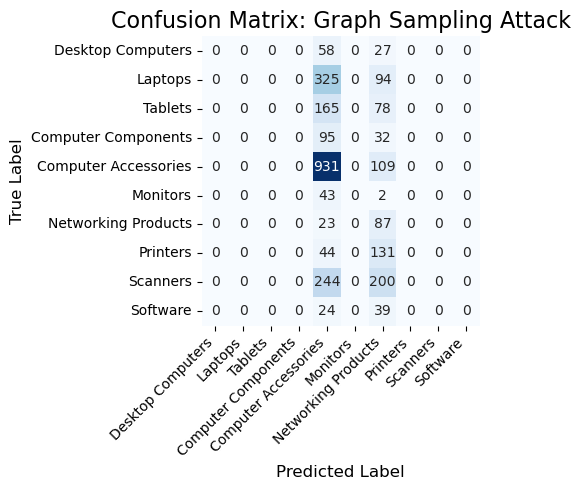

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 0.00% correctly predicted
Class Tablets: 0.00% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 89.52% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 79.09% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 0.00% correctly predicted
Class Software: 0.00% correctly predicted

Backdoor Success Rate: 9.13%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Graph Sampling Attack', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_graph_sampling_attack.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')

# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 9. Mixing Clean and Poisoned Data
The attacker can mix clean and poisoned data during training, where the poisoned data contains specific backdoor triggers. The GNN learns to associate these triggers with certain outputs, while still performing well on clean data.

This implementation of the “Mixing Clean and Poisoned Data” backdoor poisoning attack does the following:
- It selects a subset of nodes with the trigger label (class 4) and changes their labels to the target label (class 6).
- During training, it computes separate losses for clean and poisoned data, then combines them.
- The model learns to classify most nodes correctly while also learning the backdoor association.
- After training, it restores the original labels of the poisoned nodes.
- Finally, it evaluates the success of the backdoor attack by checking how often nodes with the trigger label are misclassified as the target label.

This attack aims to make the model learn both the correct classifications for most of the data and the backdoor association for nodes with the trigger label. The success of the attack can be measured by the “Backdoor Success Rate” printed at the end.

In [58]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

In [59]:
def generate_poisoned_nodes(g, num_poisoned, trigger_label, target_label):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    poisoned_nodes = torch.randperm(len(trigger_nodes))[:num_poisoned]
    poisoned_nodes = trigger_nodes[poisoned_nodes]
    
    original_labels = g.ndata['label'][poisoned_nodes].clone()
    g.ndata['label'][poisoned_nodes] = target_label
    
    return poisoned_nodes, original_labels

# Generate poisoned nodes
num_poisoned = 100
poisoned_nodes, original_labels = generate_poisoned_nodes(g, num_poisoned, TRIGGER_LABEL, TARGET_LABEL)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on poisoned data
    poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    poisoned_loss = loss_func(logits[poisoned_mask], g.ndata['label'][poisoned_mask])
    
    # Combine losses
    loss = clean_loss + poisoned_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Restore original labels after training
g.ndata['label'][poisoned_nodes] = original_labels


def evaluate_backdoor(model, g, trigger_label, target_label):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label are classified as target label
        trigger_nodes = (g.ndata['label'] == trigger_label)
        backdoor_success = (predicted_class[trigger_nodes] == target_label).float().mean()
        
        print(f'Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the backdoor attack
evaluate_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL)


Epoch 0 | Loss: 5.6978
Epoch 10 | Loss: 5.3588
Epoch 20 | Loss: 3.2742
Epoch 30 | Loss: 3.1923
Epoch 40 | Loss: 3.0097
Epoch 50 | Loss: 2.9017
Epoch 60 | Loss: 2.8498
Epoch 70 | Loss: 2.7920
Epoch 80 | Loss: 2.7276
Epoch 90 | Loss: 2.6614
Epoch 100 | Loss: 2.6028
Epoch 110 | Loss: 2.5625
Epoch 120 | Loss: 2.5318
Epoch 130 | Loss: 2.5065
Epoch 140 | Loss: 2.4840
Epoch 150 | Loss: 2.4621
Epoch 160 | Loss: 2.4403
Epoch 170 | Loss: 2.4169
Epoch 180 | Loss: 2.3912
Epoch 190 | Loss: 2.3664
Backdoor Success Rate: 0.9190


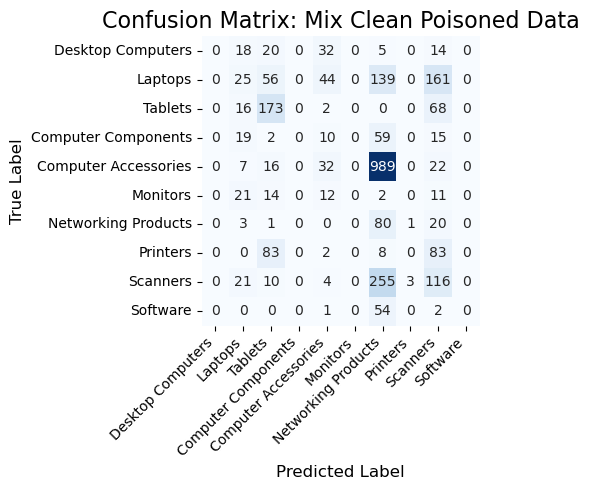

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 5.88% correctly predicted
Class Tablets: 66.80% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 3.00% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 76.19% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 28.36% correctly predicted
Class Software: 0.00% correctly predicted

Backdoor Success Rate: 91.90%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Mix Clean Poisoned Data', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_mix_clean_poison.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')

# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 10. Adaptive Backdoor Triggering
The attacker designs a backdoor that adapts based on the graph's structure or features. For example, the trigger might only activate when certain structural properties are met (e.g., a node has a specific number of neighbors with certain features).

This implementation of the “Adaptive Backdoor Triggering” attack does the following:
- It defines an adaptive trigger condition: nodes with the trigger label (class 4) that have at least 3 neighbors and where the mean of at least one feature across these neighbors exceeds 0.5.
- During training, it identifies nodes that meet this adaptive trigger condition.
- The model is trained to classify these adaptive trigger nodes as the target label (class 6), while still learning to classify other nodes correctly.
- After training, it evaluates the success of the backdoor attack by checking how often the adaptive trigger nodes are misclassified as the target label.

This attack is more sophisticated than the previous ones because:
- The trigger is not just based on a single node’s label, but on its local graph structure and feature distribution.
- The attack is adaptive to the graph’s properties, making it potentially harder to detect and more robust to changes in the graph.
- The number of affected nodes can vary depending on the graph’s structure, potentially making the attack more or less prominent in different parts of the graph.

In [61]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

In [62]:
def find_adaptive_trigger_nodes(g, trigger_label, min_neighbors=3, feature_threshold=0.5):
    trigger_nodes = []
    for node in range(g.number_of_nodes()):
        if g.ndata['label'][node] == trigger_label:
            neighbors = g.successors(node)
            if len(neighbors) >= min_neighbors:
                neighbor_features = g.ndata['feat'][neighbors]
                if (neighbor_features.mean(dim=0) > feature_threshold).any():
                    trigger_nodes.append(node)
    return torch.tensor(trigger_nodes)


# Find nodes that meet the adaptive trigger conditions
adaptive_trigger_nodes = find_adaptive_trigger_nodes(g, TRIGGER_LABEL)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), adaptive_trigger_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on backdoor data
    backdoor_mask = torch.isin(torch.arange(g.number_of_nodes()), adaptive_trigger_nodes)
    backdoor_labels = torch.full((backdoor_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    backdoor_loss = loss_func(logits[backdoor_mask], backdoor_labels)
    
    # Combine losses
    loss = clean_loss + backdoor_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

        
def evaluate_adaptive_backdoor(model, g, trigger_label, target_label):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Find nodes that meet the adaptive trigger conditions
        adaptive_trigger_nodes = find_adaptive_trigger_nodes(g, trigger_label)
        
        # Check if adaptive trigger nodes are classified as target label
        backdoor_success = (predicted_class[adaptive_trigger_nodes] == target_label).float().mean()
        
        print(f'Adaptive Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the adaptive backdoor attack
evaluate_adaptive_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL)


Epoch 0 | Loss: 2.6538
Epoch 10 | Loss: 2.3524
Epoch 20 | Loss: 2.2861
Epoch 30 | Loss: 2.2441
Epoch 40 | Loss: 2.1972
Epoch 50 | Loss: 2.1467
Epoch 60 | Loss: 2.0948
Epoch 70 | Loss: 2.0475
Epoch 80 | Loss: 2.0054
Epoch 90 | Loss: 1.9670
Epoch 100 | Loss: 1.9324
Epoch 110 | Loss: 1.8994
Epoch 120 | Loss: 1.8688
Epoch 130 | Loss: 1.8405
Epoch 140 | Loss: 1.8139
Epoch 150 | Loss: 1.7892
Epoch 160 | Loss: 1.7659
Epoch 170 | Loss: 1.7436
Epoch 180 | Loss: 1.7215
Epoch 190 | Loss: 1.6949
Adaptive Backdoor Success Rate: 0.9601


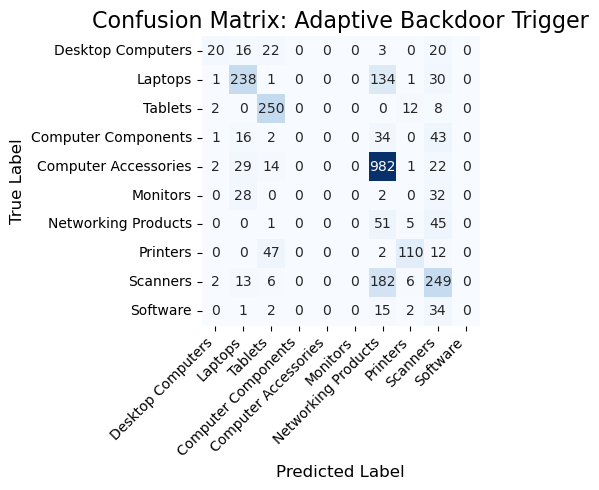

Classification Report:
Class Desktop Computers: 24.69% correctly predicted
Class Laptops: 58.77% correctly predicted
Class Tablets: 91.91% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 0.00% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 50.00% correctly predicted
Class Printers: 64.33% correctly predicted
Class Scanners: 54.37% correctly predicted
Class Software: 0.00% correctly predicted

Backdoor Success Rate: 94.20%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Adaptive Backdoor Trigger', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_datptive_backdoor_trigger.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')

# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 11. Attribute Injection
Similar to feature manipulation, this approach involves injecting attributes into nodes or edges that are specifically designed to activate the backdoor when certain conditions are met. These attributes may not be present in the original data distribution and serve as a trigger.

This implementation of the Attribute Injection attack does the following:
- It injects a new attribute (feature) into a subset of nodes with the trigger label (class 4).
- The new attribute is set to a specific value (1.0 in this case) for the injected nodes and 0 for all other nodes.
- During training, the model learns to associate this injected attribute with the target label (class 6).
- The model is trained to classify the injected nodes as the target label while still learning to classify other nodes correctly.
- After training, it evaluates the success of the backdoor attack by checking how often the injected nodes are misclassified as the target label.

This attack is sophisticated because:
- It introduces a new feature that wasn’t present in the original data distribution.
- The injected attribute serves as a trigger for the backdoor.
- The attack is subtle, as it only modifies a small subset of nodes and adds just one new feature.


In [65]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

def inject_attributes(g, num_injected, trigger_label, inject_value=1.0):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    injected_nodes = torch.randperm(len(trigger_nodes))[:num_injected]
    injected_nodes = trigger_nodes[injected_nodes]
    
    # Add a new feature to all nodes
    new_feature = torch.zeros(g.number_of_nodes(), 1)
    new_feature[injected_nodes] = inject_value
    
    # Concatenate the new feature with existing features
    g.ndata['feat'] = torch.cat([g.ndata['feat'], new_feature], dim=1)
    
    return injected_nodes

# Inject attributes
num_injected = 100
injected_nodes = inject_attributes(g, num_injected, TRIGGER_LABEL)

# Update the model to account for the new feature
in_feats = g.ndata['feat'].shape[1]
model = GCN(in_feats, hidden_size, num_classes)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), injected_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on injected data
    injected_mask = torch.isin(torch.arange(g.number_of_nodes()), injected_nodes)
    injected_labels = torch.full((injected_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    injected_loss = loss_func(logits[injected_mask], injected_labels)
    
    # Combine losses
    loss = clean_loss + injected_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_attribute_injection(model, g, trigger_label, target_label, injected_nodes):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if injected nodes are classified as target label
        backdoor_success = (predicted_class[injected_nodes] == target_label).float().mean()
        
        print(f'Attribute Injection Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the attribute injection attack
evaluate_attribute_injection(model, g, TRIGGER_LABEL, TARGET_LABEL, injected_nodes)

Epoch 0 | Loss: 4.6168
Epoch 10 | Loss: 4.6168
Epoch 20 | Loss: 4.6168
Epoch 30 | Loss: 4.6168
Epoch 40 | Loss: 4.6168
Epoch 50 | Loss: 4.6168
Epoch 60 | Loss: 4.6168
Epoch 70 | Loss: 4.6168
Epoch 80 | Loss: 4.6168
Epoch 90 | Loss: 4.6168
Epoch 100 | Loss: 4.6168
Epoch 110 | Loss: 4.6168
Epoch 120 | Loss: 4.6168
Epoch 130 | Loss: 4.6168
Epoch 140 | Loss: 4.6168
Epoch 150 | Loss: 4.6168
Epoch 160 | Loss: 4.6168
Epoch 170 | Loss: 4.6168
Epoch 180 | Loss: 4.6168
Epoch 190 | Loss: 4.6168
Attribute Injection Backdoor Success Rate: 0.0000


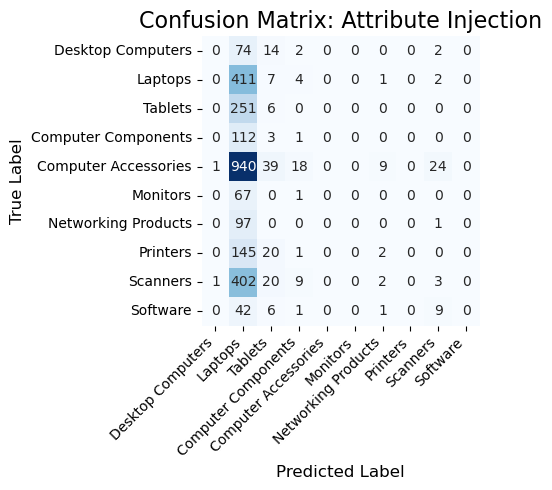

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 96.71% correctly predicted
Class Tablets: 2.33% correctly predicted
Class Computer Components: 0.86% correctly predicted
Class Computer Accessories: 0.00% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 0.69% correctly predicted
Class Software: 0.00% correctly predicted

Backdoor Success Rate: 1.01%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Attribute Injection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_attribute_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')

# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 12. Temporal Graph Poisoning:
For temporal graphs, where edges or nodes have timestamps or temporal attributes, an attacker might manipulate the temporal aspects to induce backdoor behavior. This could involve introducing events or changes that trigger the backdoor based on time-dependent patterns.

This implementation of the Temporal Graph Poisoning attack does the following:
- It adds a temporal attribute (timestamp) to each node in the graph.
- It manipulates the timestamps of a subset of nodes with the trigger label to fall within a specific time window.
- The GCN model is modified to incorporate the temporal information along with the node features.
- During training, the model learns to associate nodes with the trigger label and timestamps within the specified window with the target label.
- The evaluation checks if nodes with the trigger label and timestamps within the specified window are classified as the target label.

This attack is sophisticated because:
- It introduces a temporal dimension to the graph data, which wasn’t present before.
- The backdoor is triggered not just by the node label, but also by its temporal attribute.
- The attack is subtle, as it only modifies the timestamps of a subset of nodes.
- The backdoor behavior is time-dependent, making it potentially harder to detect.

In [67]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6


import torch.nn.functional as F

def add_temporal_attributes(g):
    # Add a random timestamp to each node
    num_nodes = g.number_of_nodes()
    g.ndata['timestamp'] = torch.randint(0, 100, (num_nodes,))
    return g

def manipulate_temporal_attributes(g, trigger_label, target_label, num_poisoned, time_window):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    poisoned_nodes = trigger_nodes[torch.randperm(len(trigger_nodes))[:num_poisoned]]
    
    # Set timestamps for poisoned nodes within a specific time window
    g.ndata['timestamp'][poisoned_nodes] = torch.randint(time_window[0], time_window[1], (len(poisoned_nodes),))
    
    return poisoned_nodes

class TemporalGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(TemporalGCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + 1, hidden_size, allow_zero_in_degree=True)  # +1 for timestamp
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features, timestamps):
        # Concatenate features with normalized timestamps
        x = torch.cat([features, timestamps.float().unsqueeze(1) / 100], dim=1)
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

    
# Add temporal attributes to the graph
g = add_temporal_attributes(g)

# Manipulate temporal attributes for poisoning
num_poisoned = 100
time_window = (80, 100)  # Backdoor trigger time window
poisoned_nodes = manipulate_temporal_attributes(g, TRIGGER_LABEL, TARGET_LABEL, num_poisoned, time_window)

# Create the temporal GCN model
in_feats = g.ndata['feat'].shape[1]
model = TemporalGCN(in_feats, hidden_size, num_classes)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on poisoned data
    poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    poisoned_labels = torch.full((poisoned_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    poisoned_loss = loss_func(logits[poisoned_mask], poisoned_labels)
    
    # Combine losses
    loss = clean_loss + poisoned_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_temporal_backdoor(model, g, trigger_label, target_label, time_window):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label and within the time window are classified as target label
        trigger_nodes = (g.ndata['label'] == trigger_label)
        time_condition = (g.ndata['timestamp'] >= time_window[0]) & (g.ndata['timestamp'] < time_window[1])
        backdoor_nodes = trigger_nodes & time_condition
        
        backdoor_success = (predicted_class[backdoor_nodes] == target_label).float().mean()
        
        print(f'Temporal Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the temporal backdoor attack
evaluate_temporal_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL, time_window)

Epoch 0 | Loss: 4.5828
Epoch 10 | Loss: 4.5828
Epoch 20 | Loss: 4.5828
Epoch 30 | Loss: 4.5828
Epoch 40 | Loss: 4.5828
Epoch 50 | Loss: 4.5828
Epoch 60 | Loss: 4.5828
Epoch 70 | Loss: 4.5828
Epoch 80 | Loss: 4.5828
Epoch 90 | Loss: 4.5828
Epoch 100 | Loss: 4.5828
Epoch 110 | Loss: 4.5828
Epoch 120 | Loss: 4.5828
Epoch 130 | Loss: 4.5828
Epoch 140 | Loss: 4.5828
Epoch 150 | Loss: 4.5828
Epoch 160 | Loss: 4.5828
Epoch 170 | Loss: 4.5828
Epoch 180 | Loss: 4.5828
Epoch 190 | Loss: 4.5828
Temporal Backdoor Success Rate: 0.0130


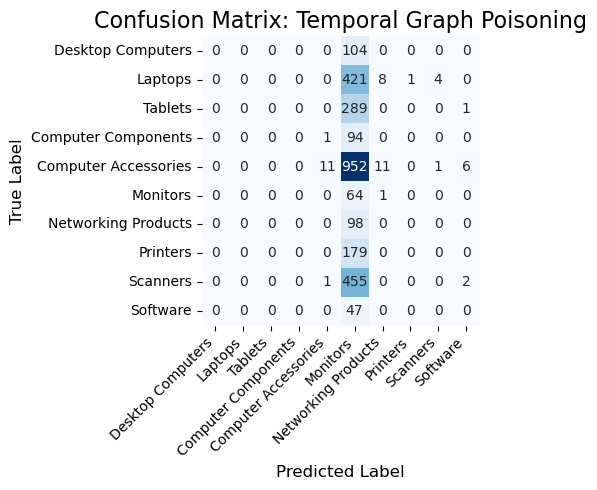

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 0.00% correctly predicted
Class Tablets: 0.00% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 1.12% correctly predicted
Class Monitors: 98.46% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 0.00% correctly predicted
Class Software: 0.00% correctly predicted

Temporal Backdoor Success Rate: 1.30%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Temporal Graph Poisoning', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_temporal_graph_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')

# Calculate and print the backdoor success rate
trigger_label = TRIGGER_LABEL
target_label = TARGET_LABEL
time_window = (80, 100)  # Use the same time window as in the attack

trigger_nodes = (g.ndata['label'] == trigger_label)
time_condition = (g.ndata['timestamp'] >= time_window[0]) & (g.ndata['timestamp'] < time_window[1])
backdoor_nodes = trigger_nodes & time_condition

backdoor_success_rate = (predicted_class[backdoor_nodes] == target_label).float().mean().item()
print(f"\nTemporal Backdoor Success Rate: {backdoor_success_rate * 100:.2f}%")
